# Load Libraries

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
import plotly.express as px

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchsummary
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Set Hyper Parameters

In [3]:
hyper_parameters = {
    "SEED":1990,
    "notebookName":"ComplexModel2",
    "nepochs":10000,
    "batch_size":256,
    "learning_rate":0.001,
    "window_size":128,
    "max_patience_count":1000
}

In [4]:
torch.manual_seed(hyper_parameters["SEED"])

In [5]:
f"./models/{hyper_parameters['notebookName']}"

'./models/ComplexModel2'

In [6]:

PATH = Path(f"./models/{hyper_parameters['notebookName']}")
if os.path.isdir(PATH):
    dir_list = os.listdir(PATH)
    num_files = 0
    while True:
        if os.path.isfile(str(PATH / f"{num_files}")):
            print(num_files)
            num_files += 1
        else:
            break
else:
    os.mkdir(PATH)
    num_files = 0
num_files = 2

# Set Path

In [7]:
data_dir = Path("../input/google-smartphone-decimeter-challenge")

# Help Functions

# Load Data

In [8]:
df_train_default = pd.read_pickle(str(data_dir / "gsdc_extract_train.pkl.gzip"))

In [9]:
df_test = pd.read_pickle(str(data_dir / "gsdc_extract_test.pkl.gzip"))

In [10]:
for col in df_train_default.columns:
    print(col)

collectionName
phoneName
millisSinceGpsEpoch
latDeg
lngDeg
heightAboveWgs84EllipsoidM
phone
timeSinceFirstFixSeconds
hDop
vDop
speedMps
courseDegree
t_latDeg
t_lngDeg
t_heightAboveWgs84EllipsoidM
constellationType
svid
signalType
receivedSvTimeInGpsNanos
xSatPosM
ySatPosM
zSatPosM
xSatVelMps
ySatVelMps
zSatVelMps
satClkBiasM
satClkDriftMps
rawPrM
rawPrUncM
isrbM
ionoDelayM
tropoDelayM
utcTimeMillis
elapsedRealtimeNanos
yawDeg
rollDeg
pitchDeg
utcTimeMillis_Status
SignalCount
SignalIndex
ConstellationType
Svid
CarrierFrequencyHz
Cn0DbHz
AzimuthDegrees
ElevationDegrees
UsedInFix
HasAlmanacData
HasEphemerisData
BasebandCn0DbHz
utcTimeMillis_UncalMag
elapsedRealtimeNanos_UncalMag
UncalMagXMicroT
UncalMagYMicroT
UncalMagZMicroT
BiasXMicroT
BiasYMicroT
BiasZMicroT
utcTimeMillis_UncalAccel
elapsedRealtimeNanos_UncalAccel
UncalAccelXMps2
UncalAccelYMps2
UncalAccelZMps2
BiasXMps2
BiasYMps2
BiasZMps2
utcTimeMillis_UncalGyro
elapsedRealtimeNanos_UncalGyro
UncalGyroXRadPerSec
UncalGyroYRadPerSec
U

# Dataloader

In [11]:
df_train_default['phone'].value_counts()

2021-04-22-US-SJC-1_Pixel4             2890
2021-04-22-US-SJC-1_SamsungS20Ultra    2826
2020-09-04-US-SF-2_Mi8                 2500
2021-04-29-US-SJC-2_SamsungS20Ultra    2370
2020-09-04-US-SF-2_Pixel4              2349
                                       ... 
2021-01-05-US-SVL-2_Pixel4XL           1193
2020-06-05-US-MTV-1_Pixel4XLModded     1123
2021-04-26-US-SVL-1_Mi8                1036
2021-04-26-US-SVL-1_Pixel5             1034
2020-05-14-US-MTV-2_Pixel4XLModded      577
Name: phone, Length: 73, dtype: int64

In [12]:
def CustomTrainValidSplit(df:pd.DataFrame, valid_size):
    phones = df['phone'].unique()
    
    valid_num = int(len(phones) * valid_size)
    train_num = len(phones) - valid_num
    
    indexes = np.array(range(len(phones)))
    indexes = np.random.choice(indexes, len(indexes))
    
    df_train = []
    for phone in phones[indexes[:train_num]]:
        df_train.append(df[df['phone'] == phone])
    df_train = pd.concat(df_train)
    
    df_valid = []
    for phone in phones[indexes[train_num:-1]]:
        df_valid.append(df[df['phone'] == phone])
    df_valid = pd.concat(df_valid)
    
    return df_train.reset_index().drop(columns = 'index'), df_valid.reset_index().drop(columns = 'index')
    
df_train, df_valid = CustomTrainValidSplit(df_train_default, valid_size = 0.1)
print(df_train.shape, df_valid.shape)
    

(118068, 148) (10863, 148)


In [13]:
df_train

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,timeSinceFirstFixSeconds,hDop,vDop,...,GPS_L1,GPS_L5,GAL_E1,GAL_E5A,GLO_G1,BDS_B1I,BDS_B1C,BDS_B2A,QZS_J1,QZS_J5
0,2021-01-05-US-SVL-2,Pixel4,1293918763441,37.379529,-122.071912,11.49,2021-01-05-US-SVL-2_Pixel4,279.44,0.8,0.0,...,0,0,0,0,0,1,0,0,0,0
1,2021-01-05-US-SVL-2,Pixel4,1293918764441,37.379528,-122.071903,11.26,2021-01-05-US-SVL-2_Pixel4,280.44,0.8,0.0,...,0,1,0,0,0,0,0,0,0,0
2,2021-01-05-US-SVL-2,Pixel4,1293918765441,37.379533,-122.071919,9.14,2021-01-05-US-SVL-2_Pixel4,281.44,0.8,0.0,...,1,0,0,0,0,0,0,0,0,0
3,2021-01-05-US-SVL-2,Pixel4,1293918766441,37.379534,-122.071917,10.77,2021-01-05-US-SVL-2_Pixel4,282.44,0.8,0.0,...,0,0,1,0,0,0,0,0,0,0
4,2021-01-05-US-SVL-2,Pixel4,1293918767441,37.379521,-122.071925,10.86,2021-01-05-US-SVL-2_Pixel4,283.44,0.8,0.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118063,2020-05-14-US-MTV-1,Pixel4,1273531198442,37.645814,-122.405615,-33.66,2020-05-14-US-MTV-1_Pixel4,2286.44,0.8,0.0,...,0,0,0,0,1,0,0,0,0,0
118064,2020-05-14-US-MTV-1,Pixel4,1273531199442,37.645819,-122.405615,-34.77,2020-05-14-US-MTV-1_Pixel4,2287.44,0.8,0.0,...,0,1,0,0,0,0,0,0,0,0
118065,2020-05-14-US-MTV-1,Pixel4,1273531200442,37.645814,-122.405599,-35.89,2020-05-14-US-MTV-1_Pixel4,2288.44,0.8,0.0,...,0,0,0,0,1,0,0,0,0,0
118066,2020-05-14-US-MTV-1,Pixel4,1273531201442,37.645812,-122.405608,-35.07,2020-05-14-US-MTV-1_Pixel4,2289.44,0.8,0.0,...,0,0,0,0,1,0,0,0,0,0


In [14]:
def GetWindowsRight(idx, window_size):
    index = np.array([])
    if idx < window_size:
        index = np.concatenate([np.zeros(window_size - idx-1), np.array(range(idx+1))])
        pass
    else:
        index = np.array(range(idx-window_size+1, idx+1))
    return index.astype(int)

def GetWindowsMid(idx, window_size, max_idx):
    left_index = np.array([])
    right_index = np.array([])
    
    left_size = int(round(window_size * 0.5))
    right_size = window_size - left_size
    if idx - left_size< 0:
        left_index = np.concatenate([np.zeros(left_size - idx-1), np.array(range(idx+1))])
    else:
        left_index = np.array(range(idx-left_size, idx+1))
    
    if idx + right_size> max_idx:
        right_index = np.concatenate([np.array(range(idx+1, max_idx+1)), (max_idx)*np.ones(right_size - (max_idx - idx) + 1)])
    else:
        right_index = np.array(range(idx+1, idx + right_size))
    
    index = np.concatenate([left_index, right_index])
    
    return index.astype(int)

def GetWindowsWithRatio(idx, max_idx, window_size, window_ratio = 1.):
    left_index = np.array([])
    right_index = np.array([])
    
    left_size = int(round(window_size * window_ratio))
    right_size = window_size - left_size
    if idx - left_size< 0:
        left_index = np.concatenate([np.zeros(left_size - idx-1), np.array(range(idx+1))])
    else:
        left_index = np.array(range(idx-left_size, idx+1))
    
    if idx + right_size> max_idx:
        right_index = np.concatenate([np.array(range(idx+1, max_idx+1)), (max_idx)*np.ones(right_size - idx - 1)])
    else:
        right_index = np.array(range(idx+1, idx + right_size))
    
    index = np.concatenate([left_index, right_index])
    
    if index.shape[0] < window_size:
        if idx > np.percentile(index, window_ratio * 100):
            if index[-1] == max_idx:
                addtional_index = index[-1]
            else:
                addtional_index = index[-1] + 1
            index = np.concatenate([index, np.array([addtional_index])])
        
    return index.astype(int)


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df:pd.DataFrame, 
                 features = ['latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM'], 
                 labels = ['t_latDeg', 't_lngDeg', 't_heightAboveWgs84EllipsoidM'],
                 window_size = 100,
                 train = False,
                 augment = False,
                 crop_ratio = 0.0,
                device = 'cpu'):
        self.df = df
        self.features = features
        self.labels = labels
        self.len = df.shape[0]
        self.window_size = window_size
        self.train = train
        self.augment = augment
        self.crop_ratio = crop_ratio
        self.device = device
        
        self.data = self.df[features].astype(float).values
        if train == True:
            self.true = self.df[labels].astype(float).values
        else:
            self.true = []
        self.phone = self.df['phone'].values
        self.millisSinceGpsEpoch = self.df['millisSinceGpsEpoch'].values
        
        self.start_index_by_phone = dict()
        self.length_by_phone = dict()
        
        for phone in set(self.phone):
            start_index = np.where(self.phone == phone)[0][0]
            self.start_index_by_phone[phone] = start_index
            self.length_by_phone[phone] = (self.phone == phone).sum().astype('int64')
            
        
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        # 필요하다면 random crop 코드도 추가(랜덤한 위치에서 일정 비율의 데이터를 0으로 초기화)
        phone = self.phone[idx]
        start_index = self.start_index_by_phone[phone]
        
#         window_index = GetWindowsWithRatio(idx - start_index, self.length_by_phone[phone], self.window_size, 1) + start_index
        window_index = GetWindowsRight(idx - start_index, self.window_size) + start_index
#         window_index = GetWindowsMid(idx - start_index, self.window_size, self.length_by_phone[phone]) + start_index
    
#         data = self.data[window_index, :].transpose(1, 0) # num_of_features X window_size
        data = self.data[window_index, :]                   # window_size X num_of_features
        
            
        indx = [self.phone[idx], self.millisSinceGpsEpoch[idx]]
        
        # data shape : num_of_features X window_size
        # true shape : num_of_labels X 1
        data = torch.Tensor(data)
        if self.augment:
            crop_size = int(self.crop_ratio * self.window_size * np.random.rand(1))
            crop_start_index = np.random.randint(0, self.window_size - crop_size)
            data[crop_start_index:crop_size] = 0
        
        if self.train is False:
            true = []
        else:
            true = self.true[idx]
            true = torch.Tensor(true.astype(float))
        
        return data, true, indx
    


## Feature Select

In [15]:
features = [
    'latDeg', 
    'lngDeg', 
    'heightAboveWgs84EllipsoidM',
    'dlatDeg_Scaled',
    'dlngDeg_Scaled',
    'dheight_Scaled',
    'xSatPosM_Scaled',
    'ySatPosM_Scaled',
    'zSatPosM_Scaled',
    'xSatVelMps_Scaled',
    'ySatVelMps_Scaled',
    'zSatVelMps_Scaled',
    'UncalGyroXRadPerSec_Scaled',
    'UncalGyroYRadPerSec_Scaled',
    'UncalGyroZRadPerSec_Scaled',
    'DriftXRadPerSec_Scaled',
    'DriftYRadPerSec_Scaled',
    'DriftZRadPerSec_Scaled',
    'UncalAccelXMps2_Scaled',
    'UncalAccelYMps2_Scaled',
    'UncalAccelZMps2_Scaled',
    'BiasXMps2_Scaled',
    'BiasYMps2_Scaled',
    'BiasZMps2_Scaled',
    'UncalMagXMicroT_Scaled',
    'UncalMagYMicroT_Scaled',
    'UncalMagZMicroT_Scaled',
    'BiasXMicroT_Scaled',
    'BiasYMicroT_Scaled',
    'BiasZMicroT_Scaled',
    'yawDeg_Scaled',
    'rollDeg_Scaled',
    'pitchDeg_Scaled',
    'GPS_L1', 
    'GPS_L5', 
    'GAL_E1', 
    'GAL_E5A', 
    'GLO_G1', 
    'BDS_B1I', 
    'BDS_B1C', 
    'BDS_B2A', 
    'QZS_J1', 
    'QZS_J5'
]
status_features = [
]

labels = [
    't_latDeg', 
    't_lngDeg', 
    't_heightAboveWgs84EllipsoidM',
#     'courseDegree',
#     'hDop',
#     'vDop',
#     'speedMps'
         ]

print(df_train[features].shape)
print(df_train[features].describe())


(118068, 43)
              latDeg         lngDeg  heightAboveWgs84EllipsoidM  \
count  118068.000000  118068.000000               118068.000000   
mean       37.440065    -122.172040                   32.740550   
std         0.085473       0.146996                   85.073555   
min        37.322844    -122.472214                -6157.470000   
25%        37.371256    -122.289617                  -22.720000   
50%        37.428118    -122.171192                   11.390000   
75%        37.486562    -122.069911                   72.192500   
max        37.690836    -121.881855                13701.980000   

       dlatDeg_Scaled  dlngDeg_Scaled  dheight_Scaled  xSatPosM_Scaled  \
count   118068.000000   118068.000000   118068.000000    118068.000000   
mean        -0.045631        0.031210       -0.019615         0.022387   
std          1.071818        1.101797        1.200591         0.812507   
min         -3.367212       -2.837517      -84.852009        -1.703958   
25%         -

In [16]:
train_data = CustomDataset(df_train, 
                           features = features, labels = labels, 
                           window_size = hyper_parameters['window_size'], 
                           train = True, 
                           augment = True,
                           crop_ratio = 0.1,
                           device = device)
valid_data = CustomDataset(df_valid, 
                           features = features, labels = labels, 
                           window_size = hyper_parameters['window_size'], 
                           train = True, 
                           augment = False,
                           crop_ratio = 0.0,
                           device = device)
test_data = CustomDataset(df_test, 
                        features = features, labels = labels, 
                        window_size = hyper_parameters['window_size'], 
                        train = False, 
                        augment = False,
                        crop_ratio = 0.0,
                        device = device)

In [17]:
train_loader = DataLoader(train_data, batch_size = hyper_parameters['batch_size'], shuffle = True)
valid_loader = DataLoader(valid_data, batch_size = hyper_parameters['batch_size'], shuffle = False)
test_loader = DataLoader(test_data, batch_size = hyper_parameters['batch_size'], shuffle = False)

# Build Model
## Define Loss and Score

In [18]:
class GPSLossScore(nn.Module):
    def __init__(self):
        super().__init__()
        self.EARTH_RADIUS = 6_367_000
        self.loss = nn.SmoothL1Loss()
        pass
    
    def forward(self, predict:torch.Tensor, target:torch.Tensor):
        loss = self.loss(predict[:,:2], target[:,:2])
        if (loss <1e-4):
            loss = self.gps_loss(predict, target)
        return loss
    
    def torch_haversine(self,lat1, lon1, lat2, lon2):
    
        lat1=lat1 % 360
        lon1=lon1 % 360
        lat2=lat2 % 360
        lon2=lon2 % 360

        lat1, lat2, lon1, lon2 = map(torch.deg2rad, [lat1, lat2, lon1, lon2])

        dlat = (lat2 - lat1)
        dlon = (lon2 - lon1)

        a = torch.sin(dlat / 2.0)**2 + torch.cos(lat1) * torch.cos(lat2) * (torch.sin(dlon / 2.0)**2)
        c = 2 * torch.arcsin(a ** 0.5)

        dist = self.EARTH_RADIUS * c

        return dist
    
    def custom_loss(self, predict:torch.Tensor, target:torch.Tensor):
        latlng_loss = self.loss(predict[:,:2], target[:,:2])
        other_loss = self.loss(predict[:,2:], target[:,2:])
        loss = 0.9 * latlng_loss + 0.1 * other_loss
        
        return loss, latlng_loss, other_loss

    def gps_loss(self, predict:torch.Tensor, target:torch.Tensor):
        dist = self.torch_haversine(predict[:,0], predict[:,1], target[:,0], target[:,1])

        loss = dist.mean()

        return loss

    def gps_score(self, predict:torch.Tensor, target:torch.Tensor):
        dist = self.torch_haversine(predict[:,0], predict[:,1], target[:,0], target[:,1])

        score = (torch.quantile(dist, 0.5) + torch.quantile(dist, 0.95))/2

        return score
    

## Build Custom Model

In [19]:

class ConvBlock(nn.Module):
    def __init__(self, input_features, features = 128):
        super().__init__()
        
        self.fuse = nn.Conv1d(input_features + features, features, kernel_size = 1)
        self.conv = nn.Conv1d(input_features, features, kernel_size=3, padding = 1)
        self.batch = nn.BatchNorm1d(features)
        self.pool = nn.AvgPool1d(kernel_size = 2)
        
    def forward(self, x):
        skip = x
        
        x = self.conv(x)
        x = F.tanh(x)
        x = self.batch(x)
        x = torch.cat([skip, x], axis = 1)
        x = self.fuse(x)
        x = self.pool(x)
        return x
    
class BaseModel(nn.Module):
    def __init__(self, input_size = (100, 3), output_size = 3):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        self.conv1 = ConvBlock(input_size[1], 64)
        self.conv2 = ConvBlock(64, 64)
        self.conv3 = ConvBlock(64, 64)
        
        self.tf = nn.Transformer(d_model = 64, 
                                 nhead = 32, 
                                 num_encoder_layers = 1, 
                                 num_decoder_layers = 1, 
                                 dim_feedforward = 64,
                                 dropout = 0.3, 
                                 activation= 'relu')
        
        self.batch_norm = nn.BatchNorm1d(64)
        self.layer_norm = nn.LayerNorm([16, 64])
        
        self.fc1 = nn.Linear(16*64, 128)
        self.layer_norm1 = nn.LayerNorm(128)
        self.fc2 = nn.Linear(128, 64)
        self.layer_norm2 = nn.LayerNorm(64)
        self.fc3 = nn.Linear(64, 32)
        self.layer_norm3 = nn.LayerNorm(32)
        self.fc4 = nn.Linear(32, output_size)
        self.layer_norm4 = nn.LayerNorm(output_size)
        
        self.drop06 = nn.Dropout(0.6)
        self.drop03 = nn.Dropout(0.3)
        self.drop01 = nn.Dropout(0.1)
        
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.kaiming_normal_(self.fc3.weight)
        nn.init.kaiming_normal_(self.fc4.weight)
        
        
    def forward(self, x):
        input_size = self.input_size 
        output_size = self.output_size
        
        x[:,:,:2] = torch.deg2rad(x[:,:,:2])
        
        x = x.transpose(2,1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.transpose(2,1)
        
        skip = x
        x = self.layer_norm(x)
        x = self.tf(x, x)
        x = self.batch_norm(x.transpose(2,1))
        x = x.transpose(2,1)
        x = x + skip
        
        x = x.reshape(-1, 16*64)
        
        x = self.drop06(x)
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.layer_norm1(x)
        
        x = self.drop06(x)
        x = self.fc2(x)
        x = F.tanh(x)
        x = self.layer_norm2(x)
        
        x = self.drop03(x)
        x = self.fc3(x)
        x = F.tanh(x)
        x = self.layer_norm3(x)
        
        x = self.drop01(x)
        x = self.fc4(x)
        x = self.layer_norm4(x)
        
        x[:,:2] = torch.rad2deg(x[:,:2])
        
        return x

## Compile Model

In [20]:
model = BaseModel((hyper_parameters['window_size'], len(features)), len(labels))
model.to(device)
# model.load_state_dict(torch.load("./models/Baseline3/model-4.pth"))

# loss_func = nn.SmoothL1Loss()
loss_func = GPSLossScore()
optimizer = optim.Adam(model.parameters(), lr = hyper_parameters['learning_rate'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                mode = 'min',
                                                factor = 0.1,
                                                patience = 5,
                                                verbose = True)

# Fit and Validate
## Train

In [21]:
def train(epoch, progress_log, status_log):
    model.train()  # 신경망을 학습 모드로 전환

    # 데이터로더에서 미니배치를 하나씩 꺼내 학습을 수행
    predict = []
    ground = []
    
    for data, targets, _ in progress_log:
        
        data = data.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()  # 경사를 0으로 초기화
        outputs = model(data)  # 데이터를 입력하고 출력을 계산
        loss = loss_func(outputs, targets)  # 출력과 훈련 데이터 정답 간의 오차를 계산
        
        loss.backward()  # 오차를 역전파 계산
        optimizer.step()  # 역전파 계산한 값으로 가중치를 수정
        
        predict.append(outputs)
        ground.append(targets)
        
        status_log.set_description_str(
            f"train status: loss - {loss_func(outputs, targets)} | {nn.SmoothL1Loss()(outputs, targets)}, score - {loss_func.gps_score(outputs, targets)}")

    # 정확도 출력
    predict = torch.cat(predict,axis = 0)
    ground = torch.cat(ground,axis = 0)
    
    loss = loss_func(predict, ground)
    meas = loss_func.gps_score(predict, ground)
    return loss, meas

## Valid

In [22]:
def valid(progress_log, status_log):
    model.eval()  # 신경망을 추론 모드로 전환

    # 데이터로더에서 미니배치를 하나씩 꺼내 추론을 수행
    predict = []
    ground = []
    
    with torch.no_grad():  # 추론 과정에는 미분이 필요없음
        for data, targets, _ in progress_log:
            
            data = data.to(device)
            targets = targets.to(device)
            
            outputs = model(data)  # 데이터를 입력하고 출력을 계산
            loss = loss_func(outputs, targets)  # 출력과 훈련 데이터 정답 간의 오차를 계산
            
            predict.append(outputs)
            ground.append(targets)
            
        status_log.set_description_str(f"valid status: loss - {loss_func(outputs, targets)} | {nn.SmoothL1Loss()(outputs, targets)}, score - {loss_func.gps_score(outputs, targets)}")
    # 정확도 출력
    predict = torch.cat(predict,axis = 0)
    ground = torch.cat(ground,axis = 0)
    
    loss = loss_func(predict, ground)
    meas = loss_func.gps_score(predict, ground)
    return loss, meas

## Test

In [23]:
def test(dataloader):
    model.eval()  # 신경망을 추론 모드로 전환
    
    output_list = []
    with torch.no_grad():  # 추론 과정에는 미분이 필요없음
        for data, _, index in tqdm(dataloader):
            data = data.to(device)
            outputs = model(data)  # 데이터를 입력하고 출력을 계산
            df_temp = pd.DataFrame()
            df_temp['phone'] = index[0]
            df_temp['millisSinceGpsEpoch'] = index[1]
            df_temp[['latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM']] = outputs[:,:3].to('cpu').numpy()
            output_list.append(df_temp)
    
    predicts = pd.concat(output_list)
    return predicts
            

In [24]:
train_loss_list = []
train_meas_list = []
valid_loss_list = []
valid_meas_list = []

patience_count = 0
min_valid_meas = np.inf
checkpoint_name = ""

epoch_prog = tqdm(range(hyper_parameters['nepochs']), position = 0, desc = "EPOCH")
epoch_status_log = tqdm(total=0, position = 2, bar_format='{desc}')
train_status_log = tqdm(total=0, position = 3, bar_format='{desc}')
valid_status_log = tqdm(total=0, position = 4, bar_format='{desc}')

if not os.path.isdir(f"./models/{hyper_parameters['notebookName']}/model-{num_files}_checkpoint/"):
    os.mkdir(f"./models/{hyper_parameters['notebookName']}/model-{num_files}_checkpoint/")
    
for epoch in epoch_prog:
    train_prog = tqdm(train_loader, position = 5, desc = 'Train', leave = False)
    valid_prog = tqdm(valid_loader, position = 6, desc = 'Valid', leave = False)

    train_loss, train_meas = train(epoch, train_prog, train_status_log)
    valid_loss, valid_meas = valid(valid_prog, valid_status_log)
    
    scheduler.step(valid_meas)
    if valid_meas < min_valid_meas:
        min_valid_meas = valid_meas
        checkpoint_name = f"./models/{hyper_parameters['notebookName']}/model-{num_files}_checkpoint/model-{epoch}-{min_valid_meas}.pth"
        torch.save(model.state_dict(), checkpoint_name)
    else:
        patience_count+=1
        if(patience_count > hyper_parameters['max_patience_count']):
            break
    
    train_loss_list.append(train_loss)
    train_meas_list.append(train_meas)
    valid_loss_list.append(valid_loss)
    valid_meas_list.append(valid_meas)
    
    status = f"EPOCH:{epoch}/{hyper_parameters['nepochs']} train status: loss - {train_loss}, score - {train_meas}, valid status: loss - {valid_loss}, score - {valid_meas}"
    epoch_status_log.set_description_str(status)

    print(status)

history = dict()
history['train_loss'] = train_loss_list
history['train_meas'] = train_meas_list
history['valid_loss'] = valid_loss_list
history['valid_meas'] = valid_meas_list


EPOCH:   0%|          | 0/10000 [00:00<?, ?it/s]

Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:0/10000 train status: loss - 10.64869213104248, score - 2547048.0, valid status: loss - 0.0036990344524383545, score - 14275.4052734375


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:1/10000 train status: loss - 0.2357868254184723, score - 148997.15625, valid status: loss - 0.004769667983055115, score - 16626.24609375


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:2/10000 train status: loss - 0.0370246060192585, score - 54453.6015625, valid status: loss - 0.0032827674876898527, score - 14828.546875


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:3/10000 train status: loss - 0.01538271177560091, score - 29413.98046875, valid status: loss - 0.0032848478294909, score - 14803.1279296875


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:4/10000 train status: loss - 0.008789917454123497, score - 22261.591796875, valid status: loss - 0.0033347452990710735, score - 14650.66796875


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:5/10000 train status: loss - 0.008954089134931564, score - 21044.734375, valid status: loss - 0.0032914485782384872, score - 14884.880859375


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch     7: reducing learning rate of group 0 to 1.0000e-04.
EPOCH:6/10000 train status: loss - 0.007380388211458921, score - 20504.12109375, valid status: loss - 0.0033512020017951727, score - 14647.115234375


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:7/10000 train status: loss - 0.007295095361769199, score - 20343.533203125, valid status: loss - 0.003294760826975107, score - 14738.4892578125


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:8/10000 train status: loss - 0.007285992614924908, score - 20327.078125, valid status: loss - 0.003299638396129012, score - 14750.296875


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:9/10000 train status: loss - 0.007282283157110214, score - 20362.03125, valid status: loss - 0.0032796873711049557, score - 14845.943359375


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:10/10000 train status: loss - 0.007279521785676479, score - 20343.19140625, valid status: loss - 0.003298269584774971, score - 14741.376953125


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:11/10000 train status: loss - 0.0072755408473312855, score - 20351.40625, valid status: loss - 0.0033108496572822332, score - 14702.9951171875


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch    13: reducing learning rate of group 0 to 1.0000e-05.
EPOCH:12/10000 train status: loss - 0.008500449359416962, score - 20359.474609375, valid status: loss - 0.0033287000842392445, score - 14734.046875


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:13/10000 train status: loss - 0.009721240028738976, score - 20350.759765625, valid status: loss - 0.0032928907312452793, score - 14747.369140625


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:14/10000 train status: loss - 0.008488046005368233, score - 20373.810546875, valid status: loss - 0.003291150089353323, score - 14758.96484375


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:15/10000 train status: loss - 0.007252485025674105, score - 20367.328125, valid status: loss - 0.003304684767499566, score - 14721.7041015625


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:16/10000 train status: loss - 0.008489404805004597, score - 20394.138671875, valid status: loss - 0.0033261291682720184, score - 14652.310546875


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:17/10000 train status: loss - 0.007254055701196194, score - 20378.328125, valid status: loss - 0.003317078575491905, score - 14684.759765625


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch    19: reducing learning rate of group 0 to 1.0000e-06.
EPOCH:18/10000 train status: loss - 0.0072543201968073845, score - 20380.34375, valid status: loss - 0.003296267008408904, score - 14753.384765625


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:19/10000 train status: loss - 0.008483029901981354, score - 20385.34765625, valid status: loss - 0.0033003538846969604, score - 14734.888671875


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:20/10000 train status: loss - 0.00848838035017252, score - 20389.17578125, valid status: loss - 0.0033028186298906803, score - 14732.830078125


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:21/10000 train status: loss - 0.0072486512362957, score - 20380.01171875, valid status: loss - 0.003302171127870679, score - 14736.7197265625


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:22/10000 train status: loss - 0.007247973699122667, score - 20366.72265625, valid status: loss - 0.0032936898060142994, score - 14754.2255859375


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:23/10000 train status: loss - 0.008481917902827263, score - 20385.30859375, valid status: loss - 0.0032956921495497227, score - 14751.8935546875


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch    25: reducing learning rate of group 0 to 1.0000e-07.
EPOCH:24/10000 train status: loss - 0.007248668000102043, score - 20394.025390625, valid status: loss - 0.0032953822519630194, score - 14749.693359375


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:25/10000 train status: loss - 0.007384386379271746, score - 20417.294921875, valid status: loss - 0.003297962713986635, score - 14738.3046875


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:26/10000 train status: loss - 0.007247761357575655, score - 20402.08984375, valid status: loss - 0.0032983862329274416, score - 14736.7919921875


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:27/10000 train status: loss - 0.007252170704305172, score - 20403.109375, valid status: loss - 0.003298630239441991, score - 14736.453125


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:28/10000 train status: loss - 0.007248518988490105, score - 20398.294921875, valid status: loss - 0.0032992754131555557, score - 14735.2099609375


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:29/10000 train status: loss - 0.007247230503708124, score - 20396.150390625, valid status: loss - 0.003299209289252758, score - 14735.435546875


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch    31: reducing learning rate of group 0 to 1.0000e-08.
EPOCH:30/10000 train status: loss - 0.008493720553815365, score - 20380.828125, valid status: loss - 0.003299238160252571, score - 14736.349609375


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:31/10000 train status: loss - 0.007246993947774172, score - 20386.34765625, valid status: loss - 0.0032992514315992594, score - 14736.171875


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:32/10000 train status: loss - 0.007248427253216505, score - 20398.31640625, valid status: loss - 0.003299257718026638, score - 14735.3779296875


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:33/10000 train status: loss - 0.007246928755193949, score - 20382.0546875, valid status: loss - 0.0032992877531796694, score - 14735.08984375


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:34/10000 train status: loss - 0.0072484975680708885, score - 20395.8984375, valid status: loss - 0.0032993326894938946, score - 14735.9296875


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:35/10000 train status: loss - 0.007248696871101856, score - 20391.0078125, valid status: loss - 0.003299337811768055, score - 14735.5830078125


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:36/10000 train status: loss - 0.007249387446790934, score - 20408.609375, valid status: loss - 0.0032993683125823736, score - 14735.1318359375


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:37/10000 train status: loss - 0.0072494191117584705, score - 20393.6328125, valid status: loss - 0.0032993811182677746, score - 14735.154296875


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:38/10000 train status: loss - 0.0072510638274252415, score - 20387.27734375, valid status: loss - 0.003299392992630601, score - 14734.83203125


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:39/10000 train status: loss - 0.007247577421367168, score - 20385.283203125, valid status: loss - 0.0032993999775499105, score - 14734.8271484375


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:40/10000 train status: loss - 0.007247263099998236, score - 20393.53125, valid status: loss - 0.003299396950751543, score - 14734.69140625


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:41/10000 train status: loss - 0.007250632159411907, score - 20397.314453125, valid status: loss - 0.003299412317574024, score - 14734.7451171875


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:42/10000 train status: loss - 0.008569448255002499, score - 20392.296875, valid status: loss - 0.0032993874046951532, score - 14734.609375


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:43/10000 train status: loss - 0.008485167287290096, score - 20394.66015625, valid status: loss - 0.0032993992790579796, score - 14734.6181640625


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:44/10000 train status: loss - 0.007251270581036806, score - 20393.357421875, valid status: loss - 0.003299396950751543, score - 14734.771484375


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:45/10000 train status: loss - 0.007248463574796915, score - 20386.9140625, valid status: loss - 0.003299411851912737, score - 14734.912109375


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:46/10000 train status: loss - 0.008479456417262554, score - 20385.31640625, valid status: loss - 0.003299387637525797, score - 14734.6416015625


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

EPOCH:47/10000 train status: loss - 0.008511876687407494, score - 20390.83203125, valid status: loss - 0.003299400443211198, score - 14734.58203125


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/43 [00:00<?, ?it/s]

KeyboardInterrupt: 

Text(0, 0.5, 'meas')

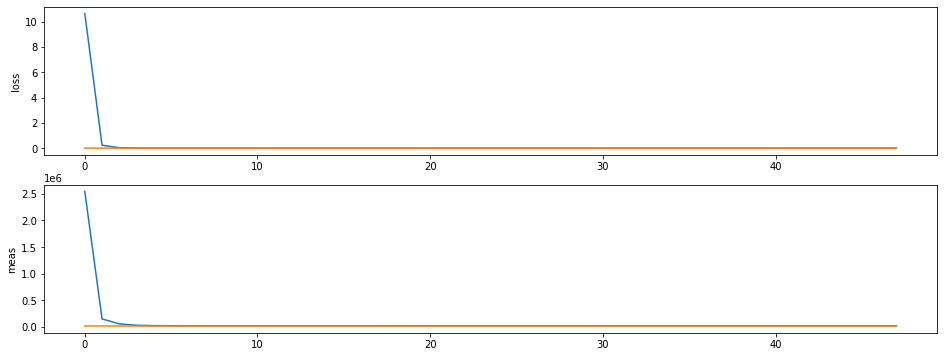

In [26]:

plt.figure(figsize = (16,6))
plt.subplot(2,1,1)
plt.plot(history['train_loss'], label = 'train')
plt.plot(history['valid_loss'], label = 'valid')
plt.ylabel('loss')

plt.subplot(2,1,2)
plt.plot(history['train_meas'], label = 'train')
plt.plot(history['valid_meas'], label = 'valid')
plt.ylabel('meas')

#  Output

In [27]:
# Load submission sample
submission = pd.read_csv(str(data_dir / "sample_submission.csv"))
print(submission.shape)
submission.head()

(91486, 4)


,phone,millisSinceGpsEpoch,latDeg,lngDeg
0,2020-05-15-US-MTV-1_Pixel4,1273608785432,37.904611,-86.481078
1,2020-05-15-US-MTV-1_Pixel4,1273608786432,37.904611,-86.481078
2,2020-05-15-US-MTV-1_Pixel4,1273608787432,37.904611,-86.481078
3,2020-05-15-US-MTV-1_Pixel4,1273608788432,37.904611,-86.481078
4,2020-05-15-US-MTV-1_Pixel4,1273608789432,37.904611,-86.481078


In [28]:
model.load_state_dict(torch.load(checkpoint_name))
torch.save(model.state_dict(), f"./models/{hyper_parameters['notebookName']}/model-{num_files}_checkpoint/model-{epoch}-{min_valid_meas}.pth")

In [29]:
predict = test(test_loader)
print(predict.shape)
predict.head()

  0%|          | 0/358 [00:00<?, ?it/s]

(91486, 5)


,phone,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM
0,2020-05-15-US-MTV-1_Pixel4XL,1273608752446,37.444633,-122.209610,0.634710
1,2020-05-15-US-MTV-1_Pixel4XL,1273608753446,37.444725,-122.209595,0.634708
2,2020-05-15-US-MTV-1_Pixel4XL,1273608754446,37.444820,-122.209572,0.634706
3,2020-05-15-US-MTV-1_Pixel4XL,1273608755446,37.444771,-122.209595,0.634706
4,2020-05-15-US-MTV-1_Pixel4XL,1273608756446,37.444691,-122.209595,0.634708


In [30]:
submission = submission[['phone', 'millisSinceGpsEpoch']].merge(predict[['phone', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']]
                                                                , on = ['phone', 'millisSinceGpsEpoch'])
print(submission.shape)
submission.head()

(91486, 4)


,phone,millisSinceGpsEpoch,latDeg,lngDeg
0,2020-05-15-US-MTV-1_Pixel4,1273608785432,37.439213,-122.210175
1,2020-05-15-US-MTV-1_Pixel4,1273608786432,37.439316,-122.210175
2,2020-05-15-US-MTV-1_Pixel4,1273608787432,37.439434,-122.210159
3,2020-05-15-US-MTV-1_Pixel4,1273608788432,37.439674,-122.210129
4,2020-05-15-US-MTV-1_Pixel4,1273608789432,37.439857,-122.210106


In [31]:
submission.to_csv(f"./models/{hyper_parameters['notebookName']}/result-{num_files}esult.csv", index = False)
pd.DataFrame([]).to_csv(PATH / f"{num_files}")